In [48]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

def make_dfs(name, chs):
    dfs = []
    for n in range(1, chs+1):
        path = f"/Users/jacobsansbury/{name}{n}.json"
        j = json.load(open(path))
        def g(d):
            res = d['results']
            res['zoomLevel'] = d['zoomLevel']
            return res
        j = [g(a) for a in j]
        dfs.append(pd.DataFrame.from_dict(j))
    return dfs

dfs = make_dfs("Results/spline-fast-new-", 3)

for df in dfs:
    df["pan_fps"] = df["avgPanFps"]
    df["backend_rt"] = df["avgBackendRoundTrip"]
    

def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

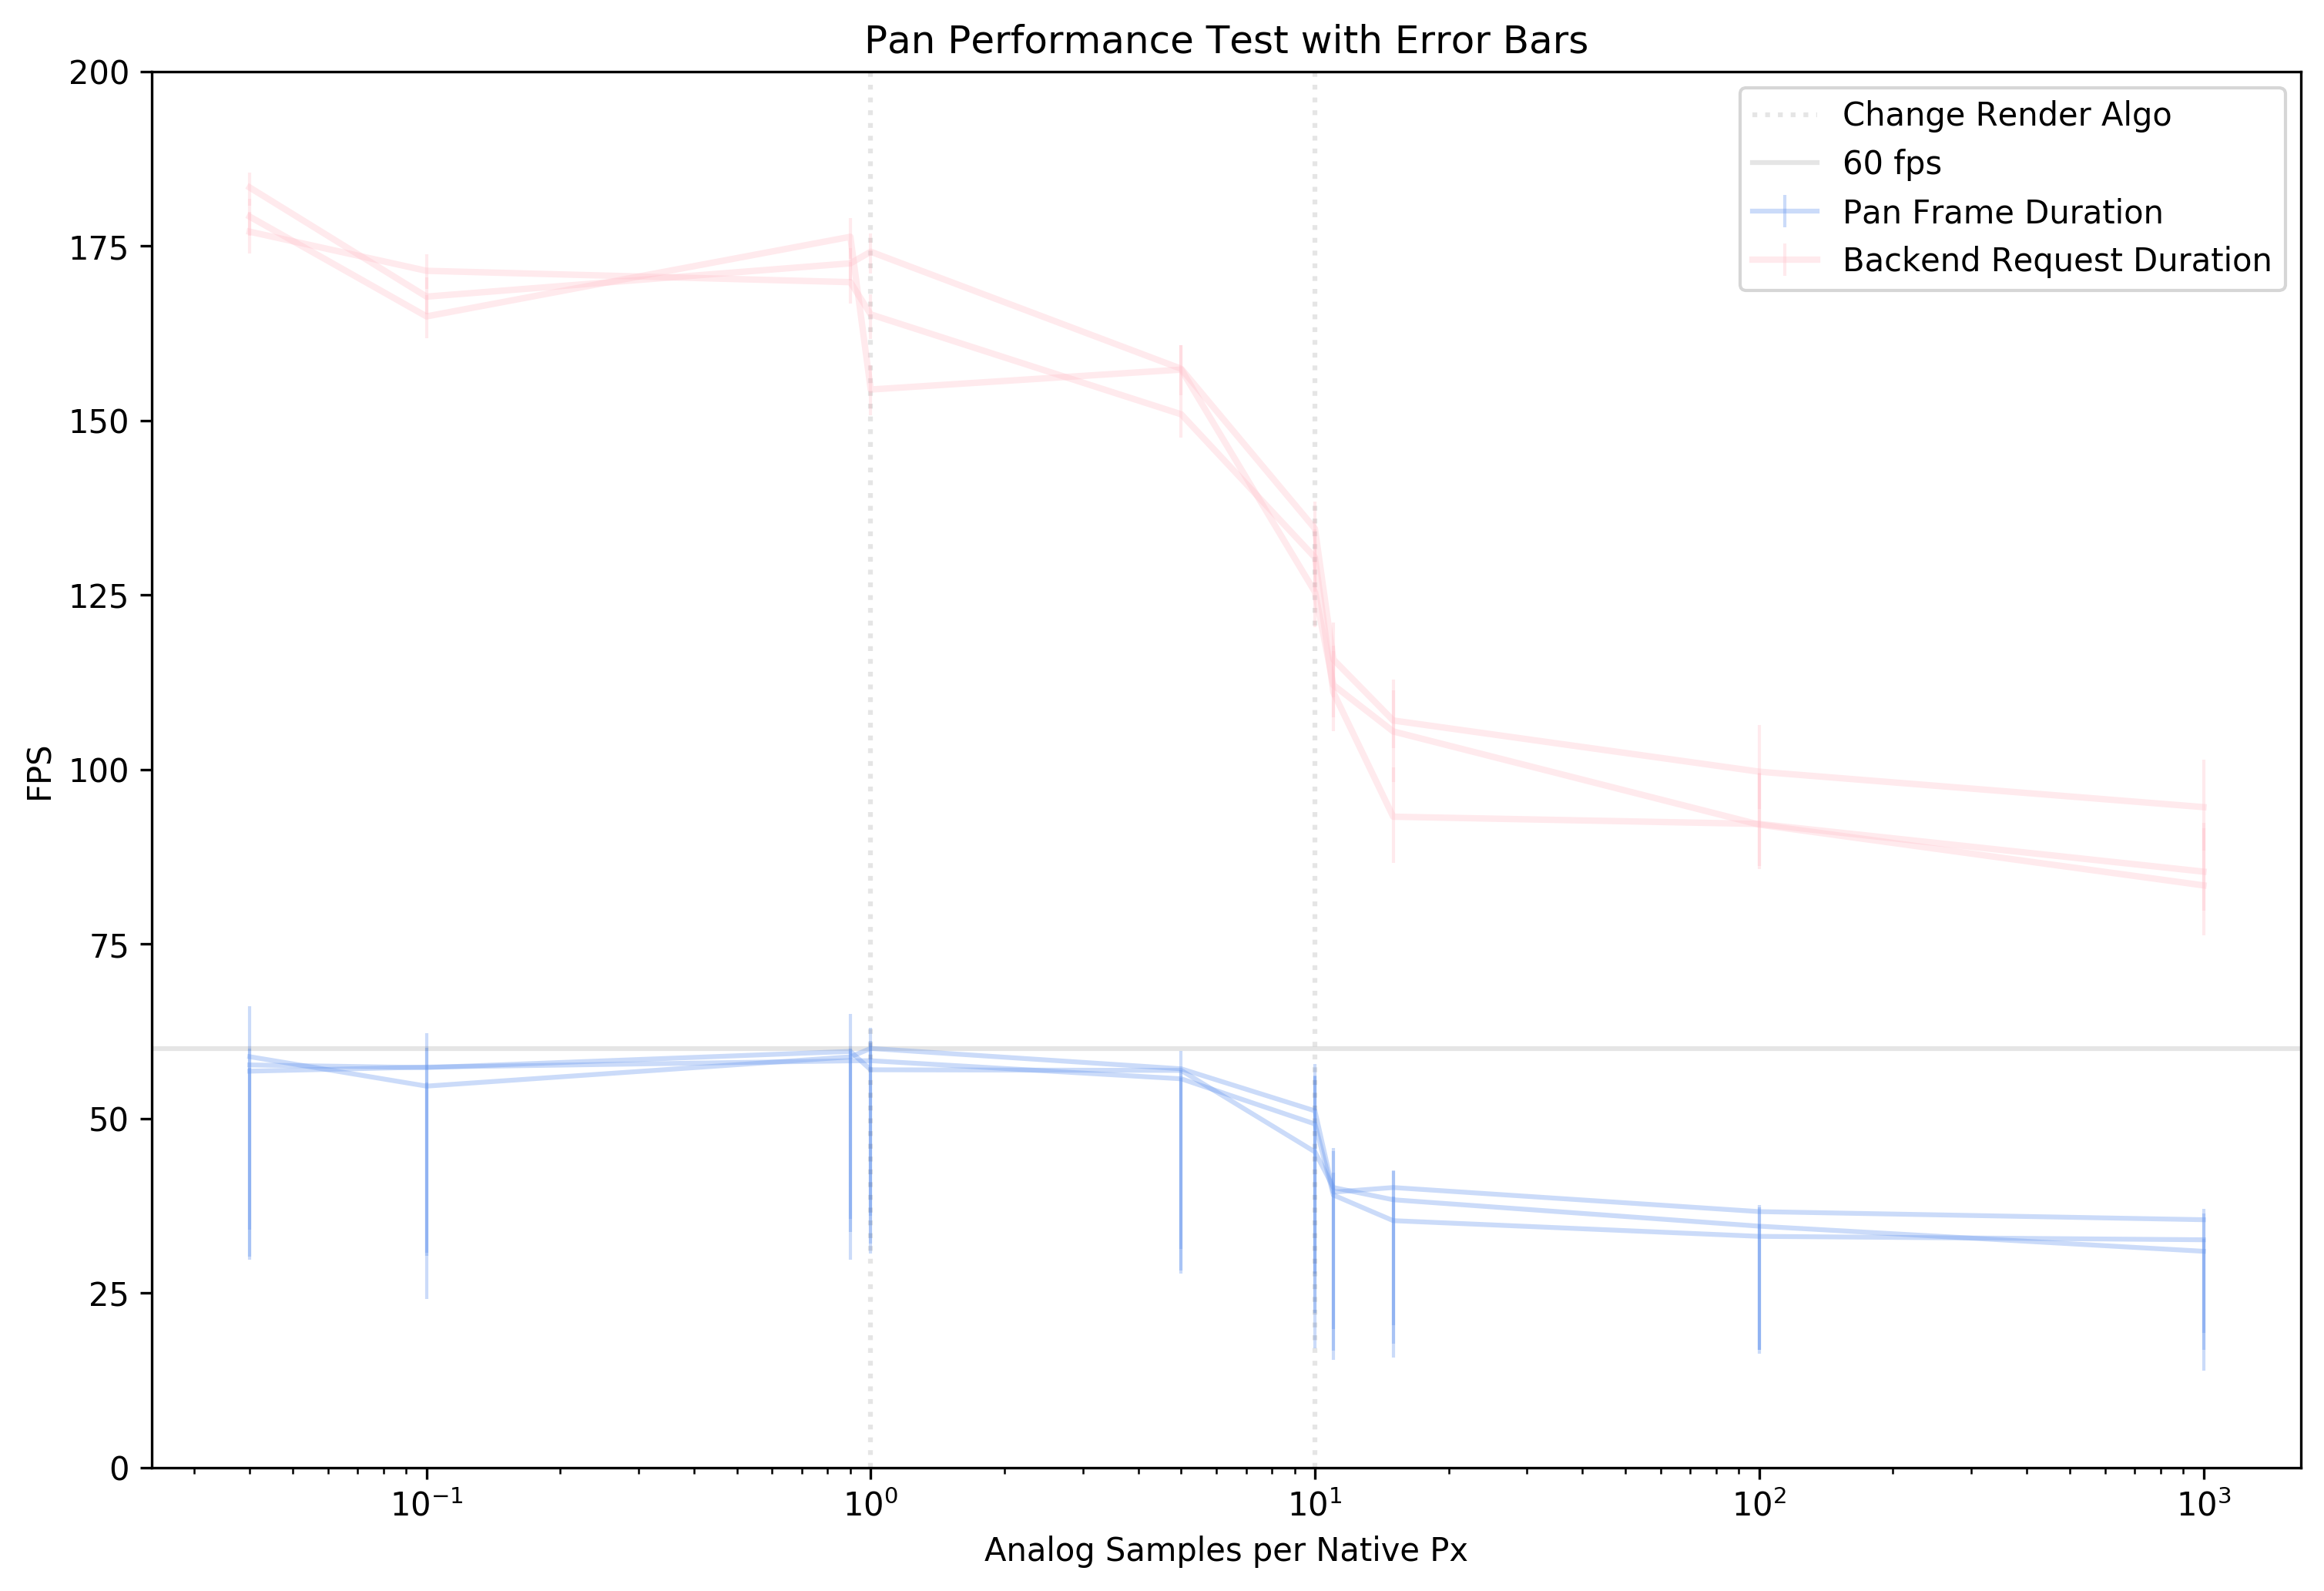

In [49]:
import matplotlib.pyplot as plt

def ebs(d):
    up = []
    low = []
    
    for i, sample in d.iterrows():
        not_outliers = np.array(sample.times)[~is_outlier(np.array(sample.times))]
        up.append(1000/max(not_outliers) - sample.pan_fps)
        low.append(sample.pan_fps - 1000/min(not_outliers))
    
    return [up, low]

def be_ebs(d):
    up = []
    low = []
    
    for i, sample in d.iterrows():
        not_outliers = np.array(sample.beTimes)[~is_outlier(np.array(sample.beTimes))]
        up.append(max(not_outliers) - sample.backend_rt)
        low.append(sample.backend_rt - min(not_outliers))
    
    return [up, low]

plt.figure(figsize=(12, 8), dpi=300)
plt.xscale('log')
plt.title('Pan Performance Test with Error Bars')
plt.xlabel('Analog Samples per Native Px')
plt.ylabel('FPS')
plt.ylim(0, 200)

alpha = 1/len(dfs)

plt.axvline(x=10, color="black", linestyle=":", alpha=0.1, label="Change Render Algo")
plt.axvline(x=1, color="black", linestyle=":", alpha=0.1)
plt.axhline(y=60, color="black", linestyle="-", alpha=0.1, label="60 fps")

for i, df in enumerate(dfs):
    if i == 1:
        plt.errorbar(df["zoomLevel"], df["pan_fps"], alpha=alpha, color="cornflowerblue", label="Pan Frame Duration", yerr=ebs(df),  elinewidth=1);
        plt.errorbar(df["zoomLevel"], 1000/df["backend_rt"],  alpha=alpha, color="pink", linewidth=2, label="Backend Request Duration", yerr=be_ebs(df),  elinewidth=1)
    else:
        plt.errorbar(df["zoomLevel"], df["pan_fps"], alpha=alpha, color="cornflowerblue", yerr=ebs(df),  elinewidth=1)
        plt.errorbar(df["zoomLevel"], 1000/df["backend_rt"],  alpha=alpha, color="pink", linewidth=2, yerr=be_ebs(df), elinewidth=1)
    
plt.legend();

In [50]:
zoom_levels = dfs[0]["zoomLevel"]

byZoomLevel = {}

for zl in zoom_levels:
    vals = []
    for df in dfs:
        vals.append(df[df["zoomLevel"] == zl]["pan_fps"])
    byZoomLevel[zl] = vals
    vals = []
    
byZoomLevel = [[float(a) for a in byZoomLevel[zl]] for zl in byZoomLevel]
    
def sq_variance(data):
    mean = sum(data) / len(data)
    sq_errors = [(d - mean)**2 for d in data]
    sq_pts = [d**2 for d in data]
    return sum(sq_errors) / sum(sq_pts)

vs = [sq_variance(d) for d in byZoomLevel]
print(sum(vs) / len(vs))

0.0011664000142497545


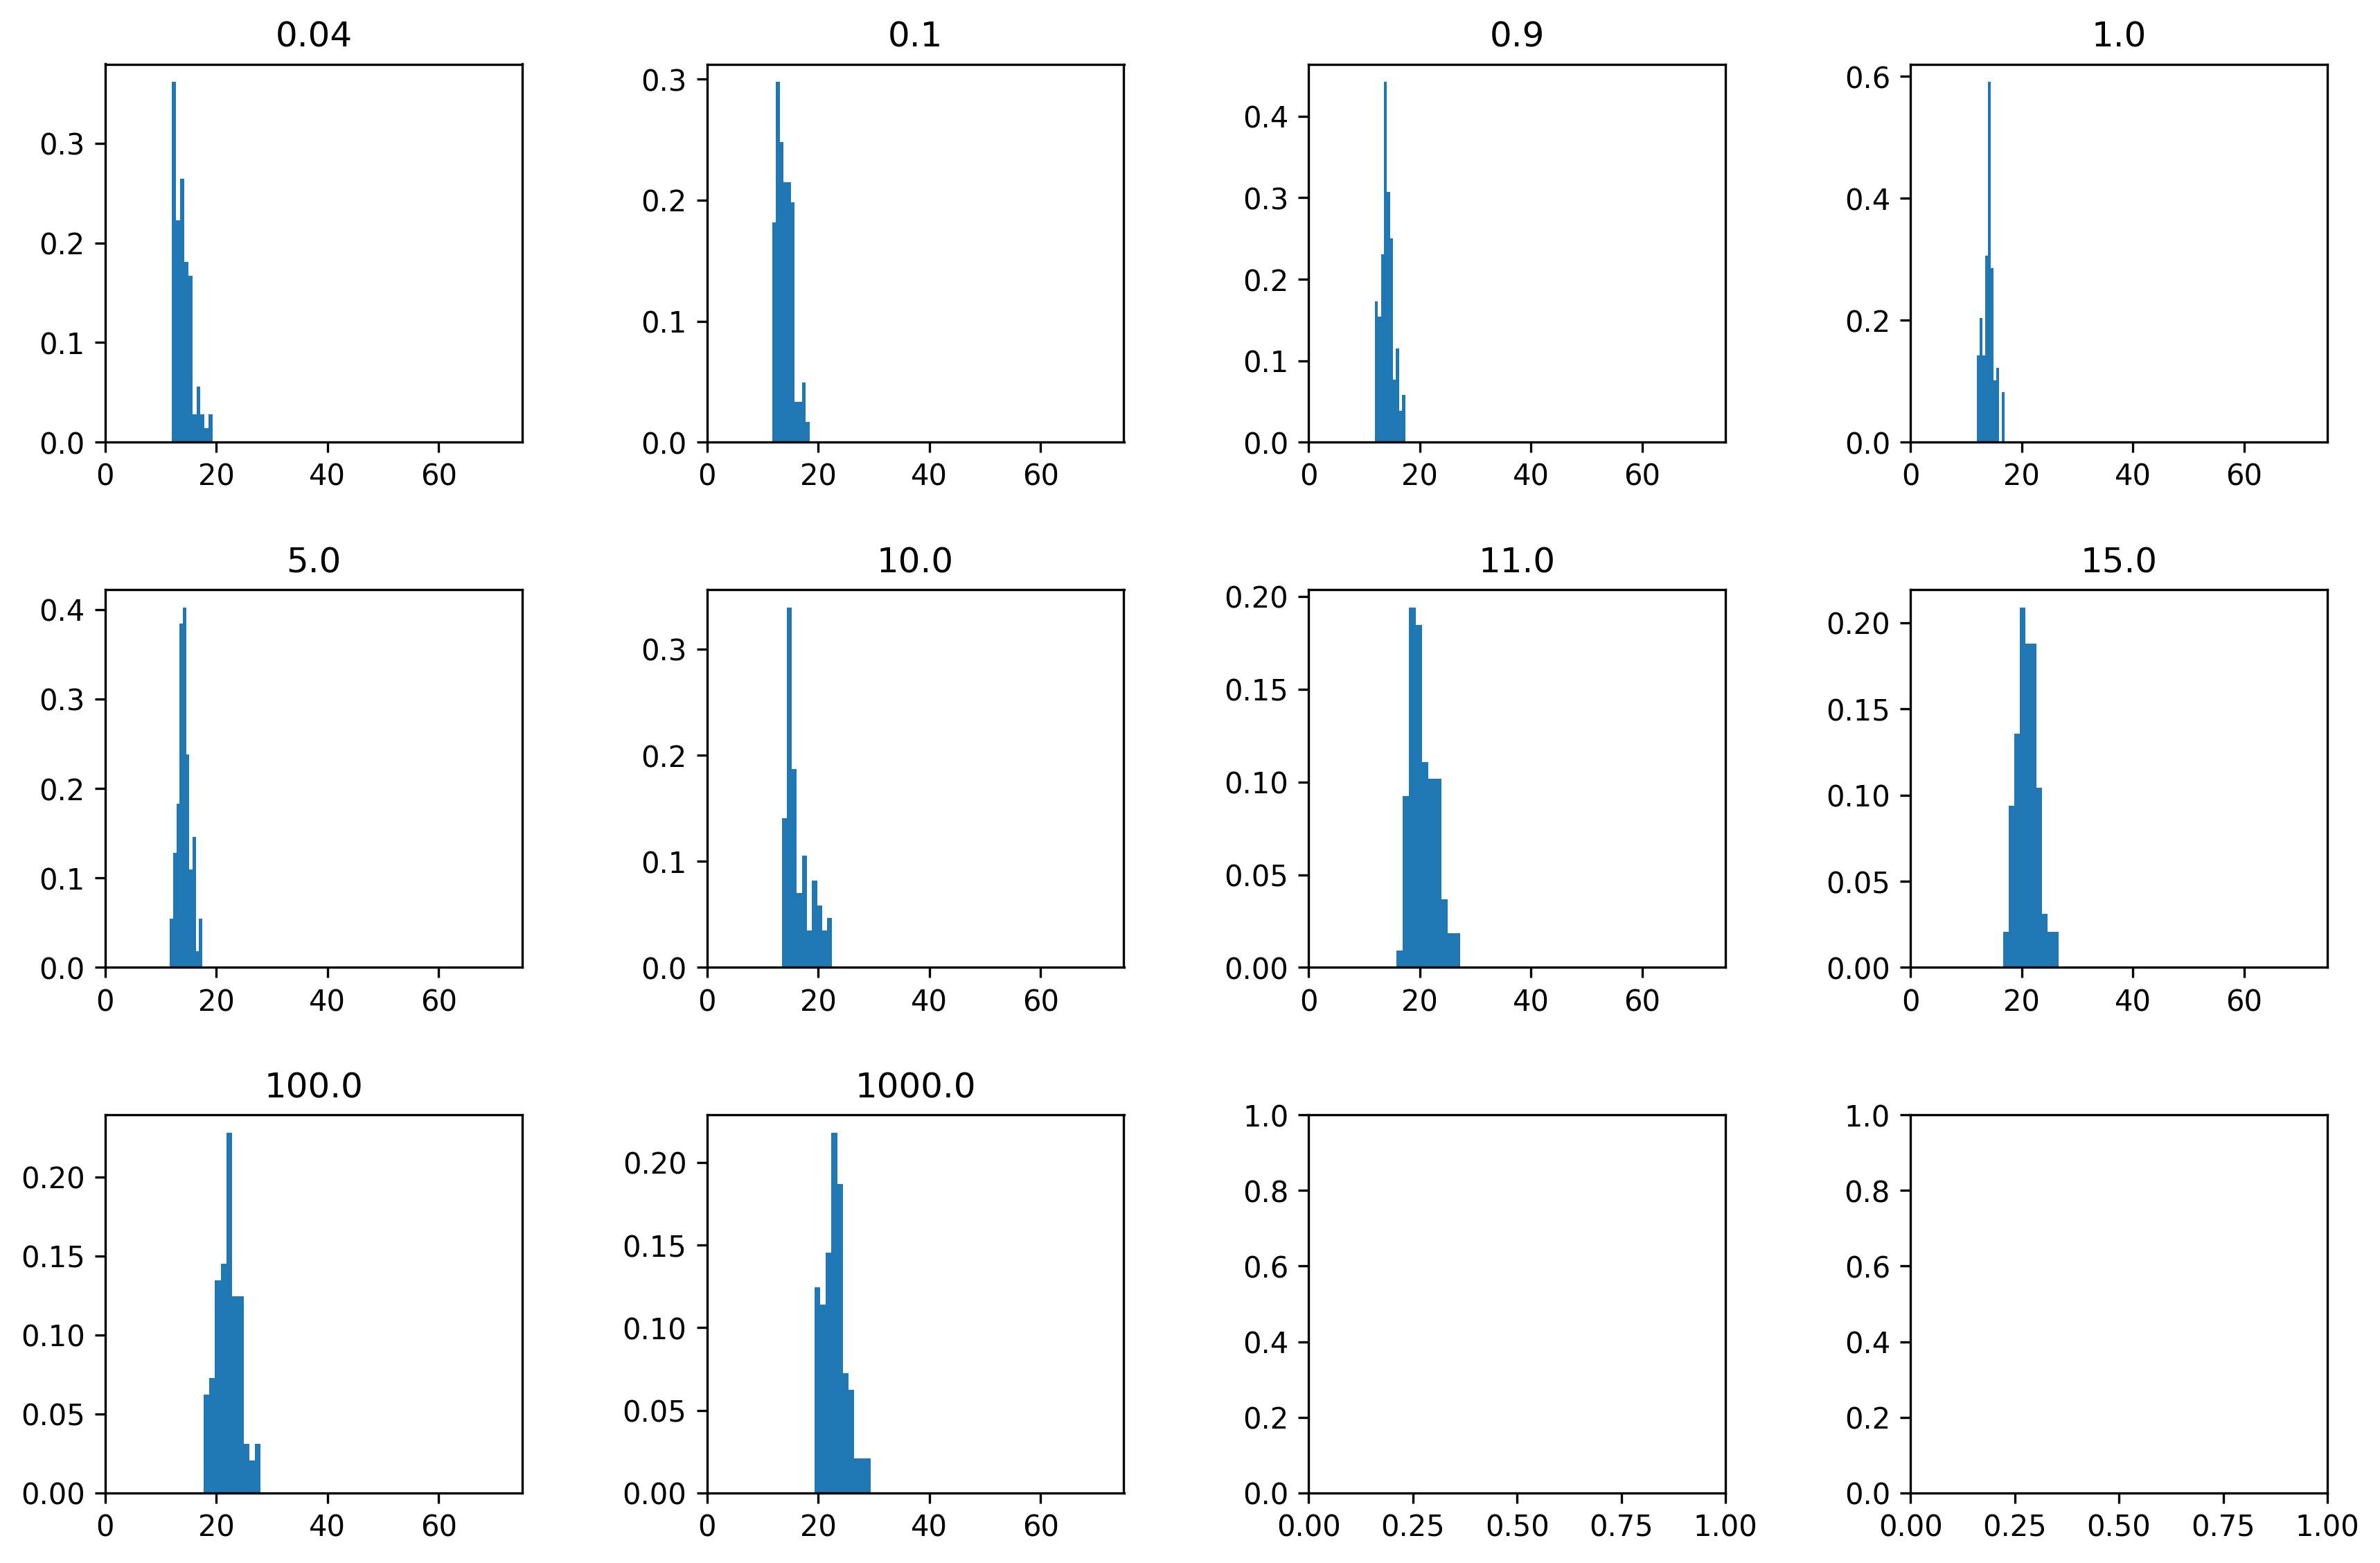

In [51]:
import math
import numpy as np

max_ax = math.floor(math.sqrt(len(d.times)))
fig, axs = plt.subplots(max_ax, math.ceil(math.sqrt(len(d.times))), figsize=(12, 8), dpi=300)
fig.tight_layout(pad=3)

in_ax = 0
a = 0
for i, level in dfs[0].iterrows():

    if in_ax > max_ax:
        a += 1
        in_ax = 0
        
    data = level.times
    data = np.array(data)
    data = data[~is_outlier(data)]
    
    axs[a, in_ax].hist(data, density=True)
    axs[a, in_ax].title.set_text(level.zoomLevel)
    axs[a, in_ax].set_xlim(0,75)
    in_ax += 1

In [66]:
dfs[0].head()

,totalDrawTime,avgPanFps,avgBackendRoundTrip,times,beTimes,zoomLevel,pan_fps,backend_rt
0,1699.305,58.847588,5.453455,"[15.199999994365498, 13.299999991431832, 12.53...","[4.765000005136244, 6.3599999994039536, 7.6000...",0.04,58.847588,5.453455
1,1830.460,54.631076,5.961847,"[536.0100000107195, 13.584999993327074, 22.760...","[4.210000013699755, 4.865000009885989, 5.36000...",0.10,54.631076,5.961847
2,1699.935,58.825779,5.796922,"[531.86000000278, 13.560000006691553, 12.75500...","[3.244999999878928, 3.9600000018253922, 4.3800...",0.90,58.825779,5.796922
3,1665.790,60.031577,5.741674,"[535.1900000096066, 13.550000003306195, 14.320...","[4.010000004200265, 4.704999999376014, 5.36500...",1.00,60.031577,5.741674
4,1750.985,57.110712,6.353379,"[536.3450000004377, 12.165000007371418, 11.624...","[3.4549999982118607, 3.974999999627471, 4.5799...",5.00,57.110712,6.353379


TypeError: '<' not supported between instances of 'list' and 'int'